# City on the Move: Insights from New York's Yellow Cabs 🚕 🇺🇸
# Case Study for LYNX BERLIN 
### by Anahit Babayan
#### Table of Contents
- [1) Data Loading, Cleanup & Feature Engineering](#data-cleanup)
    - [a) Handling Missing Values](#null)
    - [b) Feature Engineering](#engin)
- [2) Data Analysis, Descriptive Statistics](#analysis)

### <a name="data-cleanup"></a>1) Data Loading & Cleanup

In [148]:
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

In [150]:
data=pd.read_csv('Yellow_Taxi_Assignment.csv')
data.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
0,2,2018-01-01 12:02:01,2018-01-01 12:04:05,1.0,0.53,1.0,N,142,163,1,3.5,0.0,0.5,1.29,0.0,0.3,5.59,NaN,NaN
1,2,2018-01-01 12:26:48,2018-01-01 12:31:29,1.0,1.05,1.0,N,140,236,1,6.0,0.0,0.5,1.02,0.0,0.3,7.82,NaN,NaN
2,2,2018-01-01 01:28:34,2018-01-01 01:39:38,4.0,1.83,1.0,N,211,158,1,9.5,0.5,0.5,1.62,0.0,0.3,12.42,NaN,NaN
3,1,2018-01-01 08:51:59,2018-01-01 09:01:45,1.0,2.30,1.0,N,249,4,2,10.0,0.0,0.5,0.00,0.0,0.3,10.80,NaN,NaN
4,2,2018-01-01 01:00:19,2018-01-01 01:14:16,1.0,3.06,1.0,N,186,142,1,12.5,0.5,0.5,1.00,0.0,0.3,14.80,NaN,NaN


### <a name="null"></a>a) Handling Missing Values

In [153]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 304978 entries, 0 to 304977
Data columns (total 19 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   VendorID               304978 non-null  int64  
 1   tpep_pickup_datetime   304978 non-null  object 
 2   tpep_dropoff_datetime  304978 non-null  object 
 3   passenger_count        295465 non-null  float64
 4   trip_distance          304978 non-null  float64
 5   RatecodeID             295465 non-null  float64
 6   store_and_fwd_flag     295465 non-null  object 
 7   PULocationID           304978 non-null  int64  
 8   DOLocationID           304978 non-null  int64  
 9   payment_type           304978 non-null  int64  
 10  fare_amount            304978 non-null  float64
 11  extra                  304978 non-null  float64
 12  mta_tax                304978 non-null  float64
 13  tip_amount             304978 non-null  float64
 14  tolls_amount           304978 non-nu

We have 19 columns in total and 304978 rows. The null values are present in the fields such as passenger_count, RatecodeID, store_and_fwd_flag,congestion_surcharge and airport_fee. In order to understand the correct way to proceed I did a research and tried to understand what each field means and how to treat null values: 
- passenger_count: The number of passengers during the trip (may include missing or erroneous data if drivers didn’t record it properly).
- RatecodeID: Codes for the rate type applied to the trip (e.g., 1 for standard fare, 2 for JFK, 3 for Newark, etc.).
- store_and_fwd_flag: Indicates whether the trip data was stored and forwarded because the vehicle was out of communication range (e.g., "Y" for yes, "N" for no).
- congestion_surcharge: Additional fee during peak traffic hours (e.g., $2.50 introduced in recent years).
- airport_fee: Fixed fee applied to trips involving certain airport zones (e.g., JFK or Newark).

In [156]:
#Stored and forwarded flag includes either 'Yes' or 'No', thus the decision was made to flag the null values as well, as 'Unknown'. 
data['store_and_fwd_flag'].fillna('Unknown', inplace=True)
# We won't lose any data where the flag of being stored and forwarded would be 'Unknown'

In [158]:
#For passenger count, assumption is that there can't be 0 number of passengers as well as 6, since there are 5 seats including driver's.
print(data['passenger_count'].describe())
print(data['passenger_count'].value_counts())

count    295465.000000
mean          1.479126
std           1.108255
min           0.000000
25%           1.000000
50%           1.000000
75%           2.000000
max           6.000000
Name: passenger_count, dtype: float64
passenger_count
1.0    214927
2.0     43436
3.0     11642
5.0      8979
6.0      5813
0.0      5535
4.0      5133
Name: count, dtype: int64


In [160]:
# We will fill in NAs with mode, as it is the safest choice.
passenger_count_mode = data['passenger_count'].mode()[0]

# However, not only do we fill in NAs but also outlier values such as 0s and 6s.
data['passenger_count'] = data['passenger_count'].apply(
    lambda x: passenger_count_mode if pd.isnull(x) or x <= 0 or x >= 6 else x
)

In [164]:
# Let's extract the data when RatecodeID is missing
missing_ratecode_rows = data[data['RatecodeID'].isnull()]

# Now let's look at key columns such as trip_distance and fare_amount for rows with missing RatecodeID
missing_ratecode_details = missing_ratecode_rows[['tpep_pickup_datetime', 'tpep_dropoff_datetime', 'trip_distance', 'fare_amount', 'store_and_fwd_flag', 'passenger_count']]

missing_ratecode_details.head()

,tpep_pickup_datetime,tpep_dropoff_datetime,trip_distance,fare_amount,store_and_fwd_flag,passenger_count
37873,2018-08-18 14:08:00,2018-08-18 14:35:00,8.75,33.69,Unknown,1.0
40860,2018-09-06 13:00:00,2018-09-06 13:42:00,7.10,28.95,Unknown,1.0
41315,2018-09-09 13:13:00,2018-09-09 13:41:00,6.02,28.95,Unknown,1.0
42130,2018-09-14 10:32:00,2018-09-14 11:11:00,4.29,25.45,Unknown,1.0
42676,2018-09-17 10:20:00,2018-09-17 10:50:00,4.36,28.95,Unknown,1.0


Immediately, it is seen that when RatecodeID is null than the store_and_fwd_flag are null. This could be indicative of incomplete or problematic data entries. However, this is the data and we should find a way to clean it. 

In [167]:
# Calculate the average trip_distance and fare_amount for each RatecodeID
ratecode_avg = data.groupby('RatecodeID')[['trip_distance', 'fare_amount']].mean()
print(ratecode_avg)

            trip_distance  fare_amount
RatecodeID                            
1.0              2.601129    11.686628
2.0             16.871601    51.627089
3.0             16.060016    64.181159
4.0             18.651063    68.032558
5.0              5.546092    56.773124
6.0              0.000000     2.500000
99.0             6.199851    33.537127


In [172]:
# Define the function to replace RatecodeID based on trip_distance and fare_amount
def replace_ratecode(row):
    if pd.isnull(row['RatecodeID']):
        if 16.0 <= row['trip_distance'] <= 17.5 and 50 <= row['fare_amount'] <= 54:
            return 2  # Airport trip (JFK)
        elif 15.0 <= row['trip_distance'] <= 16.5 and 62 <= row['fare_amount'] <= 66:
            return 3  # Airport trip (Newark)
        elif 18.0 <= row['trip_distance'] <= 19.5 and 66 <= row['fare_amount'] <= 70:
            return 4  # Longer trip
        elif 5.0 <= row['trip_distance'] <= 6.5 and 54 <= row['fare_amount'] <= 58:
            return 5  # Other specific rate
        elif row['trip_distance'] <= 0.5 and row['fare_amount'] <= 3:
            return 6  # Surcharge fee, maybe cancellation fee?
        elif 6.0 <= row['trip_distance'] <= 7.0 and 30 <= row['fare_amount'] <= 35:
            return 99  # Rare rate, maybe an outlier
        else:
            return 0  # Placeholder for unmatched cases
    return row['RatecodeID']
# Apply the function to replace missing RatecodeID values
data['RatecodeID'] = data.apply(replace_ratecode, axis=1)

In [178]:
# These two fields are numeric but also categorical(in a way) and if the values for them are missing then it was'nt airport trip/surcharge.
# Hence, we treat nulls as 0s here.
data['airport_fee'].fillna(0, inplace=True)
data['congestion_surcharge'].fillna(0, inplace=True)

In [182]:
#Check whether we have missing values left.
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 304978 entries, 0 to 304977
Data columns (total 19 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   VendorID               304978 non-null  int64  
 1   tpep_pickup_datetime   304978 non-null  object 
 2   tpep_dropoff_datetime  304978 non-null  object 
 3   passenger_count        304978 non-null  float64
 4   trip_distance          304978 non-null  float64
 5   RatecodeID             304978 non-null  float64
 6   store_and_fwd_flag     304978 non-null  object 
 7   PULocationID           304978 non-null  int64  
 8   DOLocationID           304978 non-null  int64  
 9   payment_type           304978 non-null  int64  
 10  fare_amount            304978 non-null  float64
 11  extra                  304978 non-null  float64
 12  mta_tax                304978 non-null  float64
 13  tip_amount             304978 non-null  float64
 14  tolls_amount           304978 non-nu

### <a name="engin"></a>b) Feature Engineering

In [189]:
#  We have two dates that are provided as strings, let's convert datetime columns to proper datetime format
data['tpep_pickup_datetime'] = pd.to_datetime(data['tpep_pickup_datetime'], errors='coerce')
data['tpep_dropoff_datetime'] = pd.to_datetime(data['tpep_dropoff_datetime'], errors='coerce')

In [193]:
# Let's create a new field for trip duration in minutes
data['trip_duration_minutes'] = (data['tpep_dropoff_datetime'] - data['tpep_pickup_datetime']).dt.total_seconds() / 60

In [191]:
# It is also plausable to have the hour of pick up to identify trends or so said "busy hours".
data['hour_of_day'] = data['tpep_pickup_datetime'].dt.hour

In [195]:
# Interesting to know also the day of the week of pick up to see whether Mondays are busy or maybe Fridays.
data['day_of_week'] = data['tpep_pickup_datetime'].dt.dayofweek  
# It's flagged starting from Monday=0 and ending with Sunday=6

In [197]:
# We can also get a flag whether is was a weekend or not
data['is_weekend'] = data['day_of_week'].isin([5, 6]).astype(int)

In [201]:
# For capturing seasonality we can extract months as well
data['month_of_year'] = data['tpep_pickup_datetime'].dt.month

In [203]:
# It is also crucial to know the fare per mile 
data['fare_per_mile'] = data['fare_amount'] / data['trip_distance']

In [205]:
# Tips are huge in US, so it would be important to take a look at the tip percentages
data['tip_percentage'] = (data['tip_amount'] / data['fare_amount']) * 100

In [207]:
# We have multiple surcharges, thus it would be useful to have the total surcharge as well.
data['total_surcharge'] = data['congestion_surcharge'] + data['airport_fee'] + data['improvement_surcharge']

In [209]:
# Trip distance can be grouped into categories such as short, medium, long, etc.
bins = [0, 1, 5, 10, 20, float('inf')]
labels = ['Short', 'Medium', 'Long', 'Very Long', 'Extremely Long']
data['trip_distance_binned'] = pd.cut(data['trip_distance'], bins=bins, labels=labels)

In [211]:
# It is possible to capture traffic indicator as well since we have congestion_surcharge
data['traffic_indicator'] = (data['congestion_surcharge'] > 0).astype(int)

In [213]:
data.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,...,hour_of_day,trip_duration_minutes,day_of_week,is_weekend,month_of_year,fare_per_mile,tip_percentage,total_surcharge,trip_distance_binned,traffic_indicator
0,2,2018-01-01 12:02:01,2018-01-01 12:04:05,1.0,0.53,1.0,N,142,163,1,...,12,2.066667,0,0,1,6.603774,36.857143,0.3,Short,0
1,2,2018-01-01 12:26:48,2018-01-01 12:31:29,1.0,1.05,1.0,N,140,236,1,...,12,4.683333,0,0,1,5.714286,17.000000,0.3,Medium,0
2,2,2018-01-01 01:28:34,2018-01-01 01:39:38,4.0,1.83,1.0,N,211,158,1,...,1,11.066667,0,0,1,5.191257,17.052632,0.3,Medium,0
3,1,2018-01-01 08:51:59,2018-01-01 09:01:45,1.0,2.30,1.0,N,249,4,2,...,8,9.766667,0,0,1,4.347826,0.000000,0.3,Medium,0
4,2,2018-01-01 01:00:19,2018-01-01 01:14:16,1.0,3.06,1.0,N,186,142,1,...,1,13.950000,0,0,1,4.084967,8.000000,0.3,Medium,0


In [215]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 304978 entries, 0 to 304977
Data columns (total 29 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   VendorID               304978 non-null  int64         
 1   tpep_pickup_datetime   304978 non-null  datetime64[ns]
 2   tpep_dropoff_datetime  304978 non-null  datetime64[ns]
 3   passenger_count        304978 non-null  float64       
 4   trip_distance          304978 non-null  float64       
 5   RatecodeID             304978 non-null  float64       
 6   store_and_fwd_flag     304978 non-null  object        
 7   PULocationID           304978 non-null  int64         
 8   DOLocationID           304978 non-null  int64         
 9   payment_type           304978 non-null  int64         
 10  fare_amount            304978 non-null  float64       
 11  extra                  304978 non-null  float64       
 12  mta_tax                304978 non-null  floa

### <a name="analysis"></a>2) Data Analysis, Descriptive Statistics

In [222]:
# Summary statistics
print(data.describe())

            VendorID           tpep_pickup_datetime  \
count  304978.000000                         304978   
mean        1.672786  2020-07-16 11:54:50.074785792   
min         1.000000            2018-01-01 00:25:49   
25%         1.000000     2019-04-08 09:18:22.500000   
50%         2.000000            2020-07-17 17:01:39   
75%         2.000000     2021-10-24 11:29:50.500000   
max         6.000000            2023-01-31 23:57:28   
std         0.514069                            NaN   

               tpep_dropoff_datetime  passenger_count  trip_distance  \
count                         304978    304978.000000  304978.000000   
mean   2020-07-16 12:11:31.905307648         1.387028       4.587589   
min              2018-01-01 00:38:59         1.000000     -16.860000   
25%    2019-04-08 09:32:34.750000128         1.000000       1.000000   
50%              2020-07-17 17:17:55         1.000000       1.730000   
75%    2021-10-24 11:42:53.249999872         1.000000       3.210000   


In [ ]:
# Distribution of key variables (use histograms, boxplots, etc.)
import matplotlib.pyplot as plt
import seaborn as sns

# Trip distance distribution
plt.xlim(0, 100)
sns.histplot(data['trip_distance'], kde=True, bins=50)
plt.title('Distribution of Trip Distance')
plt.xlabel('Trip Distance (miles)')
plt.show()

# Fare amount distribution
sns.histplot(data['fare_amount'], kde=True, bins=50)
plt.title('Distribution of Fare Amount')
plt.xlabel('Fare Amount ($)')
plt.show()

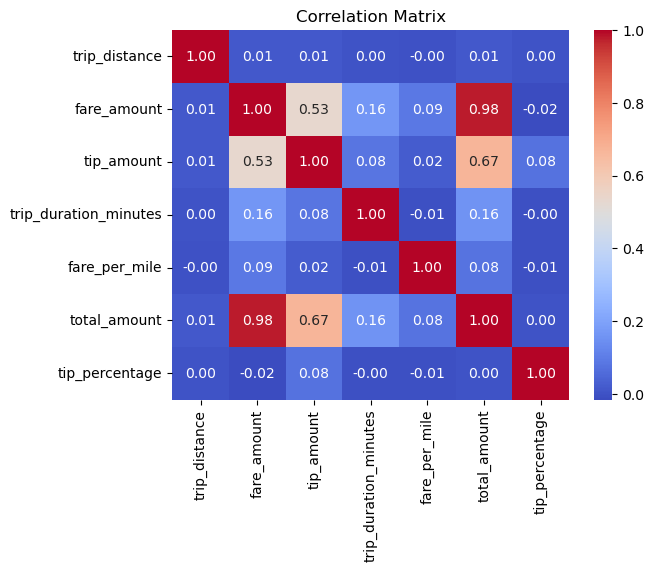

In [106]:
# Correlation matrix
corr_matrix = data[['trip_distance', 'fare_amount', 'tip_amount', 'trip_duration_minutes', 'fare_per_mile', 'total_amount', 'tip_percentage']].corr()

# Visualize the correlation heatmap
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

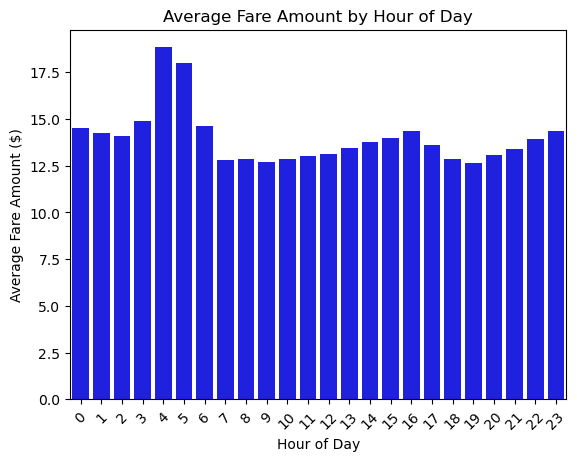

In [118]:
# Average Fare Amount by Hour of Day
hourly_avg = data.groupby('hour_of_day')['fare_amount'].mean().reset_index()
sns.barplot(x='hour_of_day', y='fare_amount', data=hourly_avg, color='blue')
plt.title('Average Fare Amount by Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Average Fare Amount ($)')
plt.xticks(rotation=45)
plt.show()

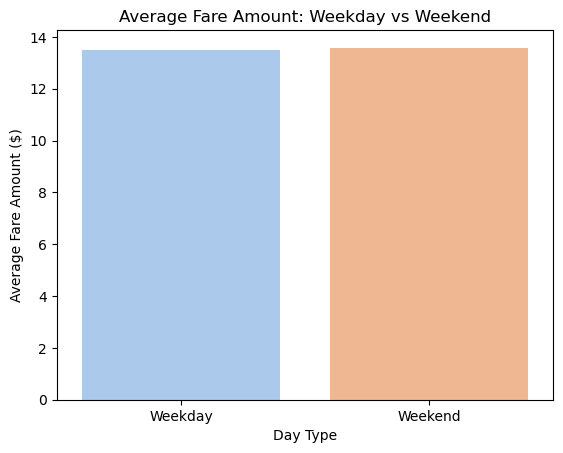

In [120]:
# Average Fare Amount for Weekday vs Weekend
weekend_avg = data.groupby('is_weekend')['fare_amount'].mean().reset_index()
weekend_avg['is_weekend'] = weekend_avg['is_weekend'].replace({0: 'Weekday', 1: 'Weekend'})
sns.barplot(x='is_weekend', y='fare_amount', data=weekend_avg, palette='pastel')
plt.title('Average Fare Amount: Weekday vs Weekend')
plt.xlabel('Day Type')
plt.ylabel('Average Fare Amount ($)')
plt.show()

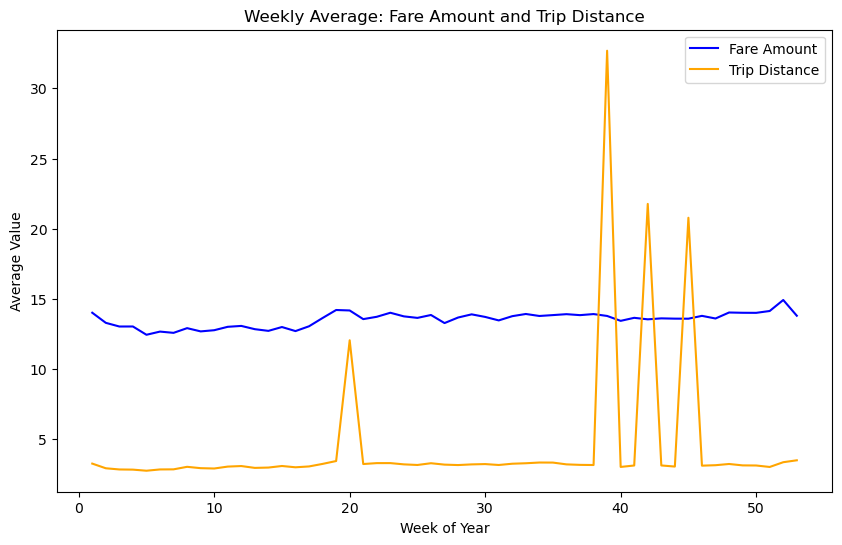

In [122]:
# Line Chart for Average Fare and Trip Distance by Week of Year
weekly_avg = data.groupby('week_of_year')[['trip_distance', 'fare_amount']].mean().reset_index()

plt.figure(figsize=(10, 6))
sns.lineplot(x='week_of_year', y='fare_amount', data=weekly_avg, label='Fare Amount', color='blue')
sns.lineplot(x='week_of_year', y='trip_distance', data=weekly_avg, label='Trip Distance', color='orange')
plt.title('Weekly Average: Fare Amount and Trip Distance')
plt.xlabel('Week of Year')
plt.ylabel('Average Value')
plt.legend()
plt.show()

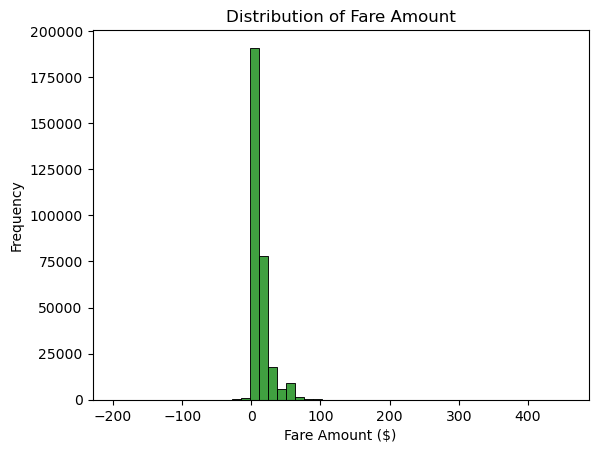

In [124]:
# Distribution of Fare Amount (Histogram)
sns.histplot(data['fare_amount'], kde=False, bins=50, color='green')
plt.title('Distribution of Fare Amount')
plt.xlabel('Fare Amount ($)')
plt.ylabel('Frequency')
plt.show()

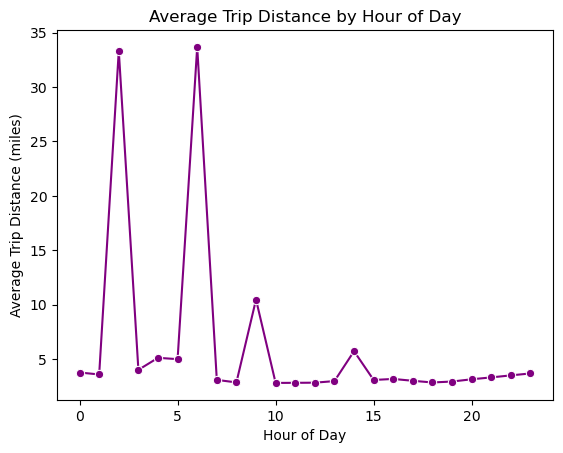

In [126]:
# Average Trip Distance by Hour of Day
hourly_trip_avg = data.groupby('hour_of_day')['trip_distance'].mean().reset_index()

sns.lineplot(x='hour_of_day', y='trip_distance', data=hourly_trip_avg, marker='o', color='purple')
plt.title('Average Trip Distance by Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Average Trip Distance (miles)')
plt.show()

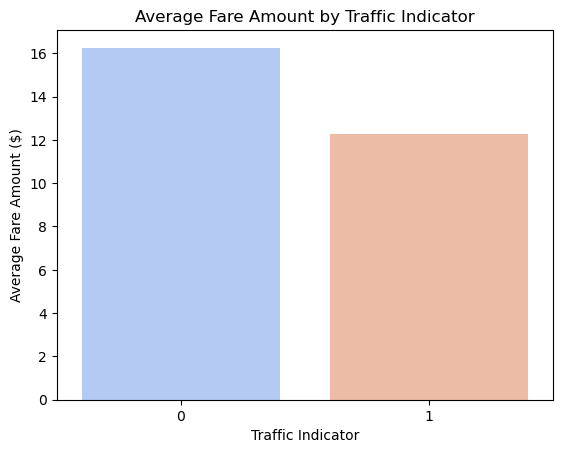

In [128]:
# Average Fare Amount by Traffic Indicator
traffic_avg = data.groupby('traffic_indicator')['fare_amount'].mean().reset_index()
sns.barplot(x='traffic_indicator', y='fare_amount', data=traffic_avg, palette='coolwarm')
plt.title('Average Fare Amount by Traffic Indicator')
plt.xlabel('Traffic Indicator')
plt.ylabel('Average Fare Amount ($)')
plt.show()

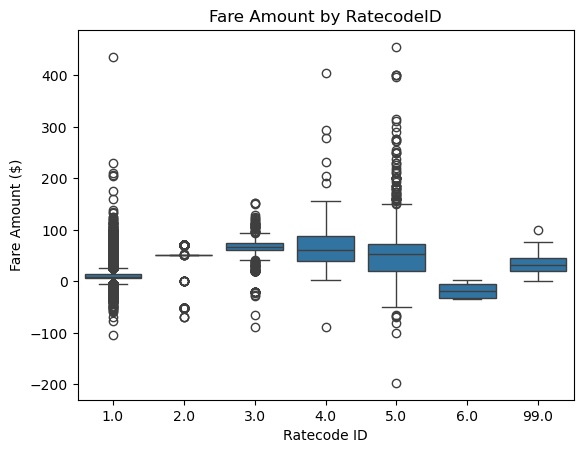

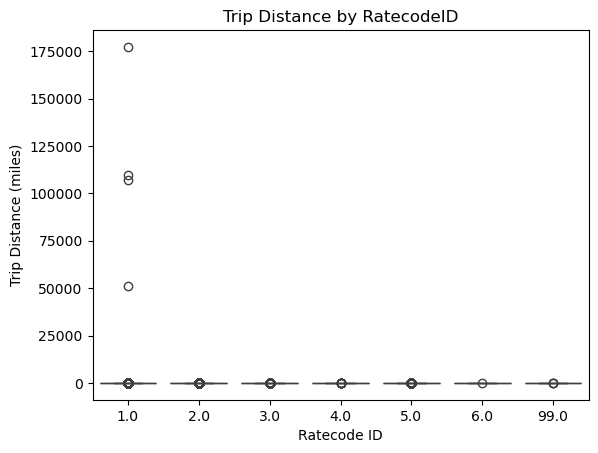

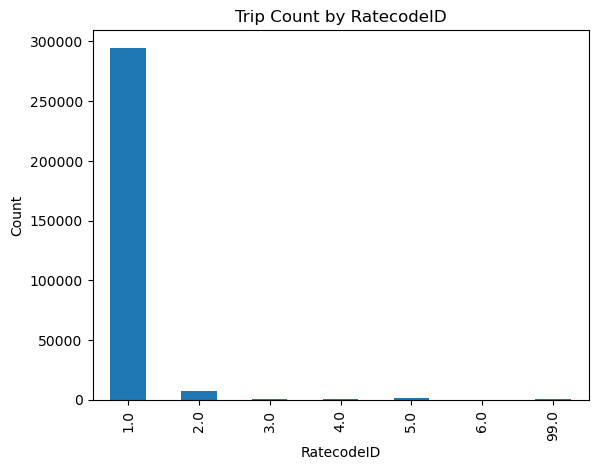

In [132]:
# RatecodeID vs fare
sns.boxplot(x='RatecodeID', y='fare_amount', data=data)
plt.title('Fare Amount by RatecodeID')
plt.xlabel('Ratecode ID')
plt.ylabel('Fare Amount ($)')
plt.show()

# RatecodeID vs trip distance
sns.boxplot(x='RatecodeID', y='trip_distance', data=data)
plt.title('Trip Distance by RatecodeID')
plt.xlabel('Ratecode ID')
plt.ylabel('Trip Distance (miles)')
plt.show()

# Count trips by RatecodeID
ratecode_counts = data['RatecodeID'].value_counts().sort_index()
ratecode_counts.plot(kind='bar', title='Trip Count by RatecodeID')
plt.xlabel('RatecodeID')
plt.ylabel('Count')
plt.show()

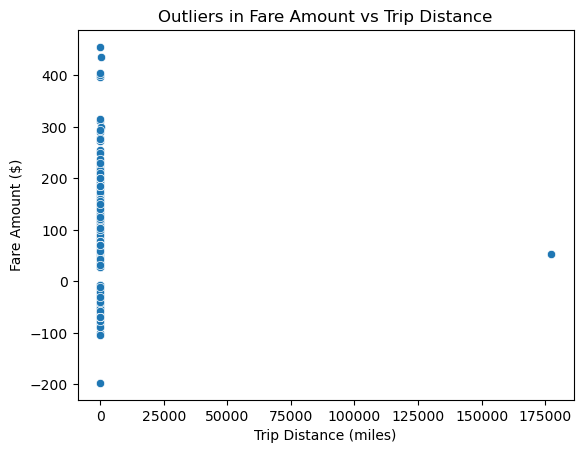

In [134]:
# Using IQR for outlier detection on fare amount
Q1 = data['fare_amount'].quantile(0.25)
Q3 = data['fare_amount'].quantile(0.75)
IQR = Q3 - Q1
outliers = data[(data['fare_amount'] < (Q1 - 1.5 * IQR)) | (data['fare_amount'] > (Q3 + 1.5 * IQR))]

# Plotting outliers
sns.scatterplot(x='trip_distance', y='fare_amount', data=outliers)
plt.title('Outliers in Fare Amount vs Trip Distance')
plt.xlabel('Trip Distance (miles)')
plt.ylabel('Fare Amount ($)')
plt.show()